# Evaluating AIWC metrics between Cuda, OpenACC and OpenCL

We present an evaluation of the change in AIWC metrics between Cuda, OpenACC and OpenCL implementations of the same 2 algorithms.
OpenCL and Cuda codes are selected from the [Rodinia Benchmark Suite](https://github.com/BeauJoh/rodinia.git) which was chosen because it's original goal was as a comparison between languages on heterogenous computing architectures. Presently it boasts Cuda, OpenCL, OpenMP and OpenACC versions of several application codes.

cocl -- as part of [coriander](https://github.com/hughperkins/coriander.git) -- is used to perform the translation of Cuda to OpenCL codes, while [OpenARC](https://csmd.ornl.gov/project/openarc-open-accelerator-research-compiler/) is used for the OpenACC to OpenCL translation.
This project assumes OpenARC is setup in the codes directory -- for instance, `aiwc-for-the-masses/codes/OpenARC`.



In [1]:
%load_ext rpy2.ipython




## Set environment variables

In [2]:
%env COCL=/coriander/bin/bin/cocl
%env NVCC=/usr/local/cuda/bin/nvcc
%env OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON

env: COCL=/coriander/bin/bin/cocl
env: NVCC=/usr/local/cuda/bin/nvcc
env: OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON


## Results
This section generates and plots the results emphasising the difference in AIWC features spaces of Gaussian Elimination and Breadth-First-Search.

### Gaussian Elimination
The following code-block generates the AIWC feature spaces for the CUDA, OpenCL and OpenACC implementations, see the [Makefile](./Makefile) (specifically test_gaussian) for details.

In [24]:
! rm -rf gaussian_results
! make test_gaussian

Makefile:106: warning: overriding recipe for target 'test_bfs'
Makefile:66: warning: ignoring old recipe for target 'test_bfs'
cd ./gaussian_openacc_version; OPENARCRT=/workspace/codes/OpenARC/openarcrt OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON ./O2GBuild.script; OPENARCRT=/workspace/codes/OpenARC/openarcrt OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON make
[AnnotParser] begin
[AnnotParser] end in 0.07 seconds
[acc2gpu] begin
[ACCAnnotParser] begin
[ACCAnnotParser] end in 0.02 seconds
[PostParserProcessor] begin


[WARNING] the current OpenARC implementation assumes that input programs follow ANSI C standard (a.k.a C89), which does not allow mixed declarations and code. However, the following procedures have mixed declarations. Please change the procedures such that all delaration statements comes before any expression statements; otherwise, incorrect translation may occur!
List of procedures with mixed declaration: BackSub, ForwardSub


[PostParserProcessor] end in 0.00 seconds
[SingleDeclarator]

Architecture-Independent Workload Characterization of kernel: Fan2
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: icmp count: 38
instruction: sub count: 32
instruction: add count: 52
instruction: store count: 8
instruction: and count: 16
instruction: ret count: 16
instruction: call count: 40
instruction: br count: 24
instruction: getelementptr count: 24
instruction: load count: 24
instruction: trunc count: 32
instruction: mul count: 12
instruction: sext count: 22
instruction: fsub count: 8
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+============================================================================+
Unique Op Codes comprising of 90% of dynamic instructions:
	add
	

Results are stored in [gaussian_results](./gaussian_results) and are partitioned by the initial language implementation.
AIWC metrics are stored as csv files and are divided by the unique kernel name and the number of iterations that the kernel was invoked.
Gaussian elimination contains two functions suitable for accelerators named Fan1 and Fan2, these are expressed as kernels in OpenCL and CUDA, and as regions of code in OpenACC expressed by pragmas. 

The results in the following sections are presented separately with respect to Fan1 and Fan2.
Each will examine the differences in AIWC feature-space between the OpenCL kernels generated by the separate OpenCL, CUDA and OpenACC implementations.
The reasons for these differences are explained by inspecting the LLVM intermediate-representation of these codes.

## Fan1

In [25]:
%%R -o fan1_invo0

# load the data
cud <- read.csv('./gaussian_results/cuda/aiwc__Z4Fan1PfS_ii_0.csv')
ocl <- read.csv('./gaussian_results/opencl/aiwc_Fan1_0.csv')
acc <- read.csv('./gaussian_results/openacc/aiwc_Fan1_kernel0_0.csv')

# tag the implementation
cud$implementation <- "cuda"
ocl$implementation <- "opencl"
acc$implementation <- "openacc"

# bring it together
fan1_invo0 <- rbind(cud,ocl,acc)


### Fan1 Absolute AIWC Counts

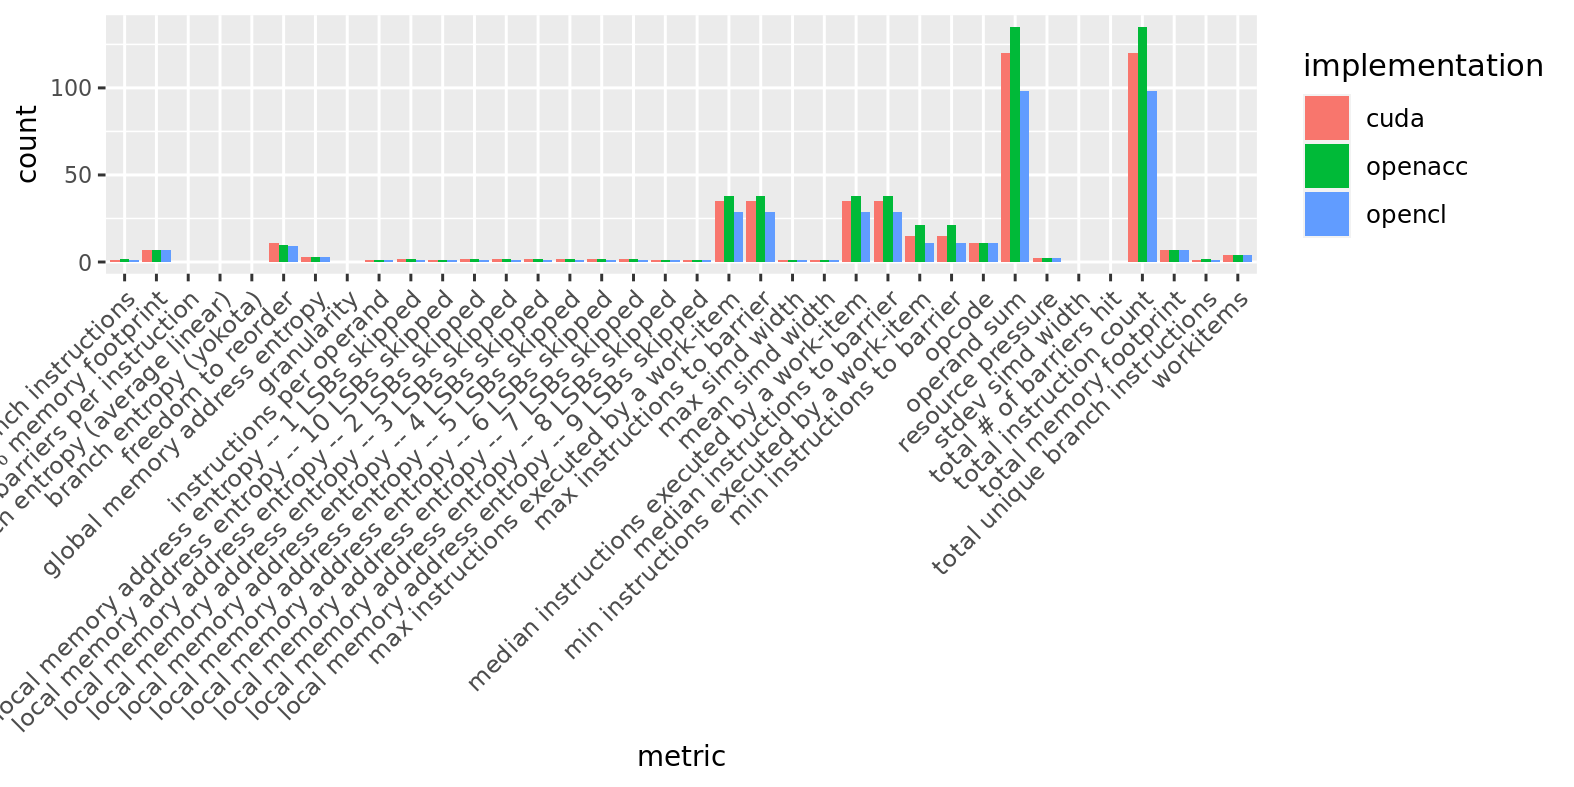

In [26]:
%%R -i fan1_invo0 -w 20 -h 10 --units cm -r 200

library('ggplot2')

p <- ggplot(data=fan1_invo0, aes(x=metric,y=count,fill=implementation)) +
        geom_bar(position="dodge",stat = "identity") +
        theme(axis.text.y = element_text(size = 8),
              axis.text.x = element_text(hjust = 1,angle=45),
              axis.title.x = element_text(size=10),
              axis.title.y = element_text(size=10))
print(p)

Initially, we performed the analysis of the feature-spaces directly from the Rodinia Benchmark Suite. However, a comparison of the AIWC metrics revealed three metrics which were largely affected by not partitioning work identically between implementations. These were `workitems`, `operand sum` and `total instruction count`. To address this, the benchmarks were modified to express an identical amount of parallelism, these changes are outlined in the following code-blocks.

Firstly, the CUDA implementation was modified in the following way:

In [6]:
! git diff pre_fan1_parallelism_changes post_fan1_parallelism_changes -- gaussian_cuda_version/gaussian.cu 

diff --git a/codes/gaussian_cuda_version/gaussian.cu b/codes/gaussian_cuda_version/gaussian.cu
index ba37d93..ed525b2 100755
--- a/codes/gaussian_cuda_version/gaussian.cu
+++ b/codes/gaussian_cuda_version/gaussian.cu
@@ -260,8 +260,8 @@ void ForwardSub()
 	cudaMemcpy(b_cuda, b, Size * sizeof(float),cudaMemcpyHostToDevice );
 	
 	int block_size,grid_size;
-	
-	block_size = MAXBLOCKSIZE;
+	//if we have smaller work to do than the max block size, just run 1 block of that size
+	block_size = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;
 	grid_size = (Size/block_size) + (!(Size%block_size)? 0:1);
 	//printf("1d grid size: %d\n",grid_size);
 
@@ -276,7 +276,7 @@ void ForwardSub()
 	
 	dim3 dimBlockXY(blockSize2d,blockSize2d);
 	dim3 dimGridXY(gridSize2d,gridSize2d);
-
+    printf("sizing info: %dx%d blocks, in a %dx%d grid\n",blockSize2d,blockSize2d,gridSize2d,gridSize2d);
     // begin timing kernels
     struct timeval time_start;
     gettimeofday(&time_start, NULL);


It is apparent the initial benchmark implementations have a variation in parallelism due to the way it is expressed in CUDA compared to OpenCL.
The `Block` size was explicitly set to the `MAXBLOCKSIZE` (512 threads), our change: `block_size = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;` states that if we have smaller work to do than the max block size, just run 1 block of that size, which mirrors the way OpenCL expresses parallelism of this benchmark -- i.e. the `global workgroup size` is the total number of threads to execute run in teams of `local workgroup size`. Thus, the CUDA implementation went from `512` workitems being invoked (where only 4 of them did any meaningful work) to `4` workitems being run.

The OpenACC implementation was also modified:

In [7]:
! git diff pre_fan1_parallelism_changes post_fan1_parallelism_changes -- gaussian_openacc_version/gaussian.c

diff --git a/codes/gaussian_openacc_version/gaussian.c b/codes/gaussian_openacc_version/gaussian.c
index 8f42354..a5f2066 100755
--- a/codes/gaussian_openacc_version/gaussian.c
+++ b/codes/gaussian_openacc_version/gaussian.c
@@ -19,9 +19,10 @@
 #include <string.h>
 
 int Size;
+int workers,gangs;
 float *a, *b, *finalVec;
 float *m;
-
+#define MAXBLOCKSIZE 512
 FILE *fp;
 
 void InitProblemOnce(char *filename);
@@ -78,7 +79,6 @@ int main(int argc, char *argv[])
     InitPerRun(m);
     //begin timing
     gettimeofday(&time_start, NULL);	
-    
     // run kernels
     ForwardSub();
     
@@ -139,7 +139,8 @@ void InitProblemOnce(char *filename)
 	//printf("The input matrix a is:\n");
 	//PrintMat(a, Size, Size);
 	b = (float *) malloc(Size * sizeof(float));
-	
+    gangs = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;
+    workers = (Size/gangs) + (!(Size%gangs)? 0:1);
 	InitAry(b, Size);
 	//printf("The input array b is:\n");
 	//PrintAry(b, Size);
@@ -171,7 +172,7 @@ void InitPer

OpenARC uses `workers` and `gangs` variables to express parallelism in the OpenACC to OpenCL setting.
To this end, we added these variables and the `MAXBLOCKSIZE` to be 512 to be equivilent to the CUDA version of the Gaussian Elimination benchmark.
`gangs = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;` is set to be analagous to `block_size` (`block_size = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;`) which we added to the CUDA version, similarly, `workers = (Size/gangs) + (!(Size%gangs)? 0:1);` is identical to the CUDA version of `grid_size` (`grid_size = (Size/block_size) + (!(Size%block_size)? 0:1);`).
Finally, the OpenACC pragmas where modified to explicitly use the `workers` and `gangs` variables: from `#pragma acc parallel loop present(m,a)` to `#pragma acc kernels loop independent gang(gangs) worker(workers)`.

It is also worth mentioning that two separate loops in the `Fan2` function were consolidated into one, to mirror how the task is performed in the OpenCL and CUDA implementations of the algorithm.

In summary, the OpenACC implementation went from `64` workitems being invoked (where only 4 of them did any meaningful work) to `4` workitems being run.

Since the OpenCL AIWC feature-space is the baseline, we should express this difference as a ratio of the CUDA and OpenACC implementations relative to the OpenCL version.

### Fan1 Relative AIWC Counts

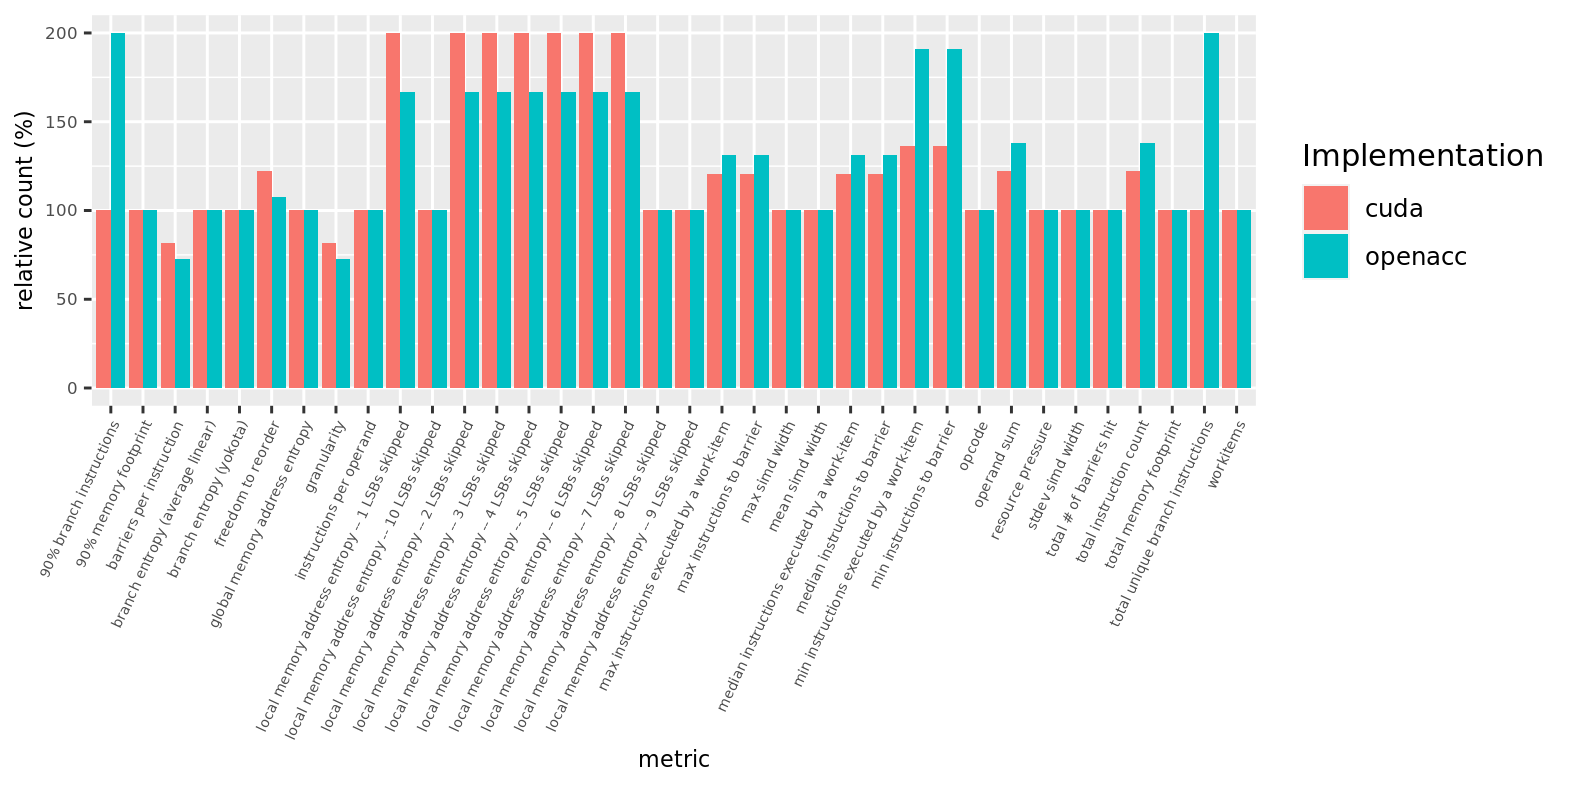

In [37]:
%%R -i fan1_invo0 -w 20 -h 10 --units cm -r 200

is.nan.data.frame <- function(x){
    do.call(cbind, lapply(x, is.nan))
}

dat <- data.frame()
for (i in unique(fan1_invo0$metric)){
    cud = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'cuda',]
    ocl = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'opencl',]
    acc = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'openacc',]
    #print(paste("Metric:",i))
    #print(paste("cuda was", cud$count))
    #print(paste("openacc was", acc$count))
    #print(paste("opencl was", ocl$count))

    cud$count = cud$count/ocl$count
    acc$count = acc$count/ocl$count
    
    #print(paste("cuda post normalization",cud$count))
    #print(paste("openacc post normalization",acc$count))

    dat <- rbind(dat,cud,acc)
}

#some metrics are 0 and divided by zero produce NaNs -- since we want to show that they are both the same when compared to the OpenCL baseline set them to be 1
dat[is.nan(dat)] <- 1

library('ggplot2')

# plot the differences in AIWC metrics
p <- ggplot(data=dat, aes(x=metric,y=count*100,fill=implementation)) +
        geom_bar(position="dodge",stat = "identity") +
        theme(axis.text.y = element_text(size = 6),
              axis.text.x = element_text(size = 5,hjust = 1,angle=65),
              axis.title.x = element_text(size=8),
              axis.title.y = element_text(size=8)) +
        labs(y = "relative count (%)",x="metric",fill="Implementation")
print(p)

In this relative figure, the CUDA and OpenACC variants would be identical if all metrics were at 100% of the OpenCL baseline counts.
Examining the generated LLVM-IR code will identify the differences between language implementations.
Firstly, the initial OpenCL version:

In [38]:
! /coriander/soft/llvm-3.9.0.bin/bin/clang -cc1 ./gaussian_opencl_version/gaussianElim_kernels.cl -emit-llvm -o ocl_kernel.ll && cat ocl_kernel.ll

./gaussian_opencl_version/gaussianElim_kernels.cl:15:15: warning: implicit declaration of function 'get_local_id' is invalid in C99
    int gid = get_local_id(0) + get_group_id(0) * get_local_size(0) ;//get_global_id(0);
              ^
./gaussian_opencl_version/gaussianElim_kernels.cl:15:33: warning: implicit declaration of function 'get_group_id' is invalid in C99
    int gid = get_local_id(0) + get_group_id(0) * get_local_size(0) ;//get_global_id(0);
                                ^
./gaussian_opencl_version/gaussianElim_kernels.cl:15:51: warning: implicit declaration of function 'get_local_size' is invalid in C99
    int gid = get_local_id(0) + get_group_id(0) * get_local_size(0) ;//get_global_id(0);
                                                  ^
./gaussian_opencl_version/gaussianElim_kernels.cl:27:18: warning: implicit declaration of function 'get_global_id' is invalid in C99
         int globalId = get_global_id(0);
                        ^
4 warnings generated.
; ModuleID

The CUDA version (the intermediate SPIR is generated directly as a compiliation step in Coriander):

In [22]:
! cp ./gaussian_opencl-device.ll ./cud_kernel.ll && cat ./cud_kernel.ll

; ModuleID = './gaussian_opencl-device-noopt.ll'
source_filename = "./gaussian_cuda_version/gaussian.cu"
target datalayout = "e-i64:64-v16:16-v32:32-n16:32:64"
target triple = "nvptx64-nvidia-cuda"

@llvm.used = appending global [1 x i8*] [i8* bitcast (i32 ()* @_ZL21__nvvm_reflect_anchorv to i8*)], section "llvm.metadata"

; Function Attrs: norecurse nounwind readnone
define internal i32 @_ZL21__nvvm_reflect_anchorv() #0 {
  ret i32 0
}

; Function Attrs: nounwind
define void @_Z4Fan1PfS_ii(float* nocapture, float* nocapture readonly, i32, i32) local_unnamed_addr #1 {
  %5 = tail call i32 @llvm.nvvm.read.ptx.sreg.tid.x() #3, !range !5
  %6 = tail call i32 @llvm.nvvm.read.ptx.sreg.ctaid.x() #3, !range !6
  %7 = tail call i32 @llvm.nvvm.read.ptx.sreg.ntid.x() #3, !range !7
  %8 = mul i32 %7, %6
  %9 = add i32 %8, %5
  %10 = add nsw i32 %2, -1
  %11 = sub i32 %10, %3
  %12 = icmp slt i32 %9, %11
  br i1 %12, label %13, label %30

; <label>:13:                                     ; preds =

Finally, OpenACC:

In [24]:
! /coriander/soft/llvm-3.9.0.bin/bin/clang -cc1 gaussian_openacc_version/bin/openarc_kernel.cl -emit-llvm -o acc_kernel.ll && cat acc_kernel.ll

gaussian_openacc_version/bin/openarc_kernel.cl:31:13: warning: implicit declaration of function 'get_global_id' is invalid in C99
_ti_100_501=get_global_id(0);
            ^
gaussian_openacc_version/bin/openarc_kernel.cl:33:18: warning: implicit declaration of function 'get_num_groups' is invalid in C99
if (_ti_100_501<(get_num_groups(0)*workers))
                 ^
2 warnings generated.
; ModuleID = 'gaussian_openacc_version/bin/openarc_kernel.cl'
source_filename = "gaussian_openacc_version/bin/openarc_kernel.cl"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

; Function Attrs: nounwind
define void @Fan1_kernel0(float* nocapture readonly %a, float* nocapture %m, i32 %Size, i32 %gangs, i32 %t, i32 %workers) local_unnamed_addr #0 !kernel_arg_addr_space !1 !kernel_arg_access_qual !2 !kernel_arg_type !3 !kernel_arg_base_type !3 !kernel_arg_type_qual !4 {
  %call = tail call i32 (i32, ...) bitcast (i32 (...)* @get_global_id to i32 (i3

When we examine the differences between the OpenCL and CUDA versions of this function, we notice the structure of the entry point (`define`) to be largely the same -- these are named `Fan1` and `_Z4Fan1PfS_ii` with respect to version. Both functions have three successive calls to get local and global thread ids and aquiring the size of the workgroup.

We see a slightly different structure in the OpenACC version with an additional comparison and jump form the definition of the `Fan1_kernel0` function which goes to an additional `preheader` but has the same `add` -> `sub` -> `icmp` -> `br` that is included in the definition of the OpenCL and CUDA variations.
This explains why the OpenACC version contains twice the number of `90% branch instructions` and `total unique branch instructions` than the OpenCL and CUDA variations -- as shown in the [absolute](#Fan1-Absolute-AIWC-Counts) and [relative](#Fan1-Relative-AIWC-Counts) Figures.

## Fan2

# Conclusions and Future Work

We show that the Architecture Independent Workload Characterisation methodology can be extended to also be generally language agnostic.
This is demonstrated by taking a OpenCL implementation and comparing it to a CUDA and OpenACC variations of the same task -- all implementations are functionally equivilent with work partitioned to exhibit the same degree/granularity of parallelism.

Language-Agnostic Architecture-Independent Workload Characterization is useful for a range of domains, in scheduling, optimization and node configuration.
With this in mind, we dedicate the remained of the paper to our contributions and future work separated by domain.

Scheduling:

* Most existing HPC codes are written in OpenMP and OpenACC with newer revised editions of scientific codes having a CUDA variation. However OpenCL implementations of these codes are rare. By showing that the statistics around the fundamental computational characteristics of the workload are largely fixed and removed from the language of which it is written, the existing AIWC method can be employed.
* Variations in compiler optimization and toolchain used, the same predictive methodology can be applied to separately trained response-times. (**TODO** add flow-chart figure and a better description.)
* Accurate predictions of a kernels execution time without having to be first primed (measured by empirically running the same kernel over as many devices as are available) (**TODO** finish)

Optimization:

* Some best practices are shared between accelerator architectures and vendors as is shown in the  -- this is our current area of research and is left as future work.
* The presented methodology has promise when we consider FPGAs (**TODO** finish this thought)

Node Configuration:

* Accelerator hardware vendors IP and scientific HPC establishments IP (**TODO** flesh out this thought)

The only other variation of language common to accelerators in scientific HPC is OpenMP.
While currently not included in this work, the next version of OpenARC promises support for OpenMP.
All kernels presented in our work has an OpenMP variatiant ready to go and we will be added in the future.

The justification in selecting the AIWC metrics was that they were believed to measure the essential characteristics of scientific codes removed from, and irrespective of, the given architecture.
It is reassuring that the same rational is true for language implementation; that measurable statistics about a programs properties (such as branching, memory access, etc) capture the essence of the task and that this is true irrespective of both language in which it is expressed and architecture on which it is run.

# Extras: Specifics about compiling the codes and running the tests


## Compile Cuda code using standard nvidia compiler 

In [2]:
! $NVCC ./gaussian_cuda_version/gaussian.cu -o gaussian_cuda

## Compile OpenCL version of the Cuda code using cocl

In [3]:
! $COCL ./gaussian_cuda_version/gaussian.cu -o gaussian_opencl


Please use: `cocl_py`, which is easier to maintain, and portable

cocl args: ./gaussian_cuda_version/gaussian.cu -o gaussian_opencl
LLVM_COMPILE_FLAGS -I/coriander/coriander/soft/llvm-4.0/include -D_GNU_SOURCE -D__STDC_CONSTANT_MACROS -D__STDC_FORMAT_MACROS -D__STDC_LIMIT_MACROS -I/coriander/coriander/soft/llvm-4.0/include -fPIC -fvisibility-inlines-hidden -Wall -W -Wno-unused-parameter -Wwrite-strings -Wcast-qual -Wmissing-field-initializers -pedantic -Wno-long-long -Wcovered-switch-default -Wnon-virtual-dtor -Wdelete-non-virtual-dtor -Wstring-conversion -Werror=date-time -std=c++11 -ffunction-sections -fdata-sections -fexceptions -D_GNU_SOURCE -D__STDC_CONSTANT_MACROS -D__STDC_FORMAT_MACROS -D__STDC_LIMIT_MACROS
+ /coriander/coriander/soft/llvm-4.0/bin/clang++ -DUSE_CLEW -std=c++11 -x cuda -D__CORIANDERCC__ -D__CUDACC__ --cuda-gpu-arch=sm_30 -nocudalib -nocudainc --cuda-device-only -emit-llvm -O2 -S -Wno-gnu-anonymous-struct -Wno-nested-anon-types -I/coriander/coriander/soft/llvm-4.

## Functionality test of the OpenCL generated version

The code must produce the same results regardless of the compiler and backend before any further evaluation is performed.

In [4]:
! ./gaussian_cuda ./matrix4.txt

Matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

Matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
   -0.00     0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

Array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 0.00 -0.40 -0.50 


Time total (including memory transfers)	1.115455 sec
Time for CUDA kernels:	0.000068 sec


In [5]:
! ./gaussian_opencl ./matrix4.txt

OpenCL platform: NVIDIA CUDA
OpenCL device: Tesla P100-PCIE-12GB
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
Matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

Matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
    0.00    -0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

Array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 -0.00 -0.40 -0.50 


Time total (including memory transfers)	1.504010 sec
Time for CUDA kernels:	0.339834 sec


## Functionality test of the generated vs hand-coded versions

Next, we test for the same functionality against a manually written version.

### Compile the hand-coded version

In [6]:
!cd gaussian_opencl_version/ && g++ gaussianElim.cpp  clutils.cpp utils.cpp -lOpenCL -std=c++11 -o gaussian_hand_opencl && cd ..
!mv gaussian_opencl_version/gaussian_hand_opencl . && cp gaussian_opencl_version/gaussianElim_kernels.cl .

clutils.cpp: In function '_cl_context* cl_init(char)':
clutils.cpp:223:24: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)' is deprecated [-Wdeprecated-declarations]
     commandQueueProf = clCreateCommandQueue(context, device, 
                        ^
In file included from clutils.cpp:57:0:
/usr/include/CL/cl.h:1359:1: note: declared here
 clCreateCommandQueue(cl_context                     /* context */,
 ^
clutils.cpp:223:24: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)' is deprecated [-Wdeprecated-declarations]
     commandQueueProf = clCreateCommandQueue(context, device, 
                        ^
In file included from clutils.cpp:57:0:
/usr/include/CL/cl.h:1359:1: note: declared here
 clCreateCommandQueue(cl_context                     /* context */,
 ^
clutils.cpp:224:63: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_i

In [7]:
! ./gaussian_hand_opencl ./matrix4.txt -p 0 -d 0

Using Platform 0 	 Device No 0 
Creating GPU Context

	gaussianElim_kernels.cl
The result of matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

The result of matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
    0.00    -0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

The result of array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 -0.00 -0.40 -0.50 



## AIWC feature-space comparison between the generated and hand-coded version

Here they should be similar enough to show that AIWC and it's OpenCL back-end is suitable for language agnostic architecture-independent workload characterization

In [10]:
! $OCLGRIND_BIN --aiwc ./gaussian_hand_opencl matrix4.txt -p 0 -d 0

Using Platform 0 	 Device No 0 
This Context Type Not Supported
: Success
	gaussianElim_kernels.cl
Architecture-Independent Workload Characterization of kernel: Fan1
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: getelementptr count: 18
instruction: load count: 6
instruction: br count: 7
instruction: sext count: 9
instruction: call count: 4
instruction: add count: 10
instruction: trunc count: 4
instruction: store count: 3
instruction: icmp count: 4
instruction: mul count: 6
instruction: ret count: 4
instruction: sub count: 4
instruction: fdiv count: 3
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+============================================================================+
Un

In [12]:
! $OCLGRIND_BIN --aiwc ./gaussian_opencl ./matrix4.txt

OpenCL platform: Oclgrind
OpenCL device: Oclgrind Simulator
Architecture-Independent Workload Characterization of kernel: _Z4Fan1PfS_ii
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: sub count: 512
instruction: bitcast count: 515
instruction: icmp count: 512
instruction: mul count: 518
instruction: trunc count: 1536
instruction: store count: 3
instruction: fdiv count: 3
instruction: ret count: 512
instruction: add count: 1030
instruction: br count: 515
instruction: load count: 6
instruction: getelementptr count: 533
instruction: call count: 1536
instruction: sext count: 9
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+===========================================================

Architecture-Independent Workload Characterization of kernel: _Z4Fan1PfS_ii
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: sub count: 512
instruction: bitcast count: 513
instruction: icmp count: 512
instruction: mul count: 514
instruction: sext count: 3
instruction: call count: 1536
instruction: getelementptr count: 519
instruction: load count: 2
instruction: br count: 513
instruction: add count: 1026
instruction: trunc count: 1536
instruction: fdiv count: 1
instruction: store count: 1
instruction: ret count: 512
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+============================================================================+
Unique Op Codes comprising of 90% of dyna